This exercise is based on the paper https://arxiv.org/pdf/2112.01031.pdf In this exercise you essentially redo section 3 of the paper.

In [ ]:
import os
from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D

You can estimate how fast a network prediction can be calculated by calculating the number of floating point operations performed in the network. This function is a handy tool to do it. Use it like this `print(get_flops(my_model))` where `my_model` is your KERAS neural network model.

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import tensorflow as tf
######################################Calculate FLOPS##########################################
def get_flops(model):
    '''
    Calculate FLOPS
    Parameters
    ----------
    model : tf.keras.Model
        Model for calculating FLOPS.

    Returns
    -------
    flops.total_float_ops : int
        Calculated FLOPS for the model
    '''

    batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + list(model.inputs[0].shape[1:]), model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

Downloading the data (1 signal data file and 5 noise data files)

In [ ]:
# download data file that contains signal events
if not os.path.exists("trimmed100_data_signal_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq


Downloading...
From: https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq
To: /content/trimmed100_data_signal_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 89.8MB/s]


In [ ]:
# download data file that contains noise events
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0001.npy"):
  !gdown https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0002.npy"):
  !gdown https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0003.npy"):
  !gdown https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0004.npy"):
  !gdown https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0005.npy"):
  !gdown https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx

Downloading...
From: https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
To: /content/trimmed100_data_noise_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:01<00:00, 72.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
To: /content/trimmed100_data_noise_3.6SNR_1ch_0001.npy
100% 80.0M/80.0M [00:00<00:00, 149MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
To: /content/trimmed100_data_noise_3.6SNR_1ch_0002.npy
100% 80.0M/80.0M [00:00<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
To: /content/trimmed100_data_noise_3.6SNR_1ch_0003.npy
100% 80.0M/80.0M [00:00<00:00, 199MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
To: /content/trimmed100_data_noise_3.6SNR_1ch_0004.npy
100% 80.0M/80.0M [00:00<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx
To: /con

Load the data into memory and combine it into one array.

In [ ]:
# load signal and noise data set into memory
noise = np.load("trimmed100_data_noise_3.6SNR_1ch_0000.npy")
for i in range(1,5):
  noise = np.vstack((noise,np.load(f"trimmed100_data_noise_3.6SNR_1ch_000{i}.npy")))
signal = np.load("trimmed100_data_signal_3.6SNR_1ch_0000.npy")
n_classes = 2

In [ ]:
# combine noise and signal data set
x = np.vstack((noise, signal))
#x = np.reshape(x, (x.shape[0], -1))
print(x.shape)
# in case you want to train a CNN, you need to add an empty dimension to the array
# which you can do via x = np.expand_dims(x, axis=-1)

# 2d convolution requires 2 empty dimensions
#x = np.expand_dims(x, axis=-1)
x = np.expand_dims(x, axis=-1)
print(x.shape)
n_samples = x.shape[1]

# define labels. As we have only two categories, we don't use one-hot encoding
# but can just use "0" for noise and "1" for signal.
y = np.ones(len(x))
y[:len(noise)] = 0

(599997, 100)
(599997, 100, 1)


Currently, the training data first contains all noise events and then only signal events. This is not optimal, especially because Keras will pick the last X% of the data set for the validation data (which would mean we train only on noise and then validate with signal, which does not make much sense). Therefore, we randomly shuffle the dataset. Important: The x and y arrays need to be shuffled identicially as in the code below.

In [ ]:
# shuffel the data
shuffle = np.arange(x.shape[0], dtype=int)
np.random.shuffle(shuffle)
x = x[shuffle]
y = y[shuffle]

# to still be able to identify the signal events you can do
smask = y == 1
# then you can get all signal events via `x[smask]`
# and all noise events via `x[~smask]`


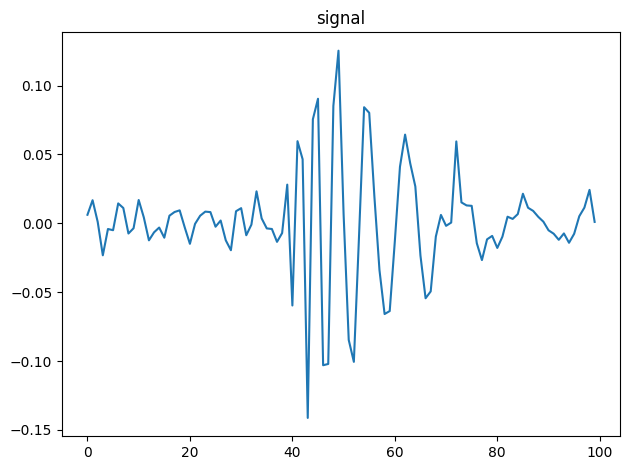

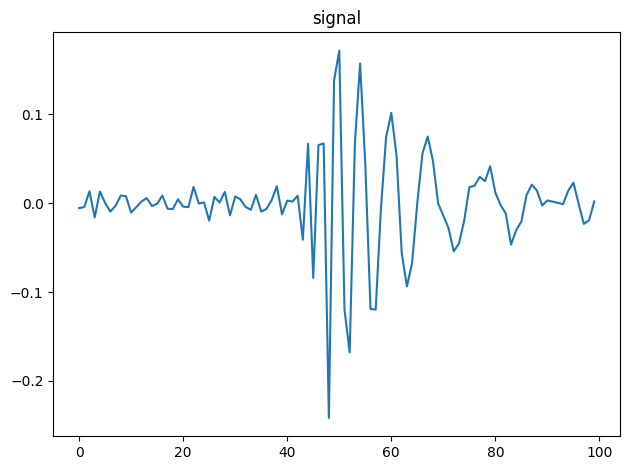

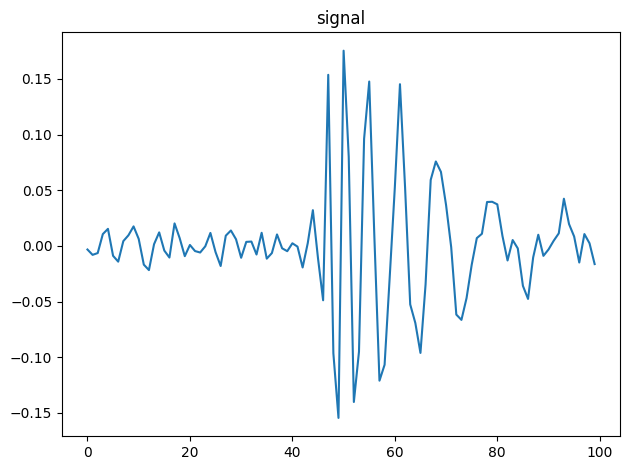

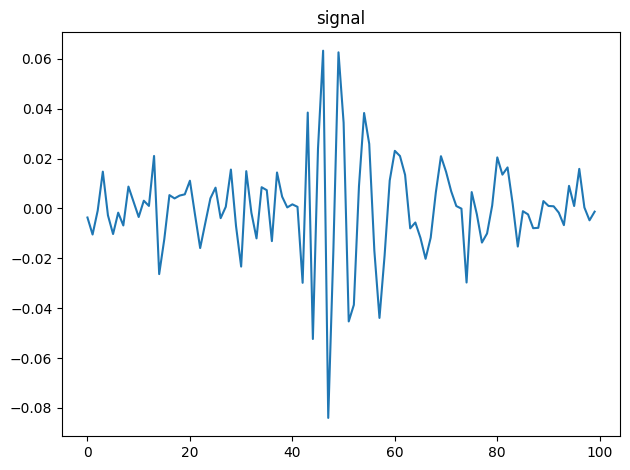

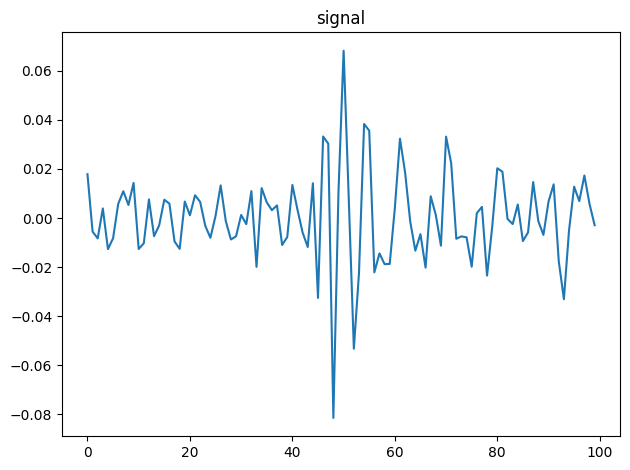

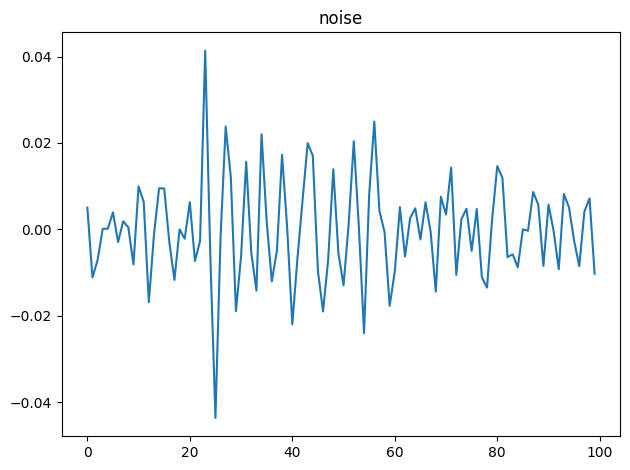

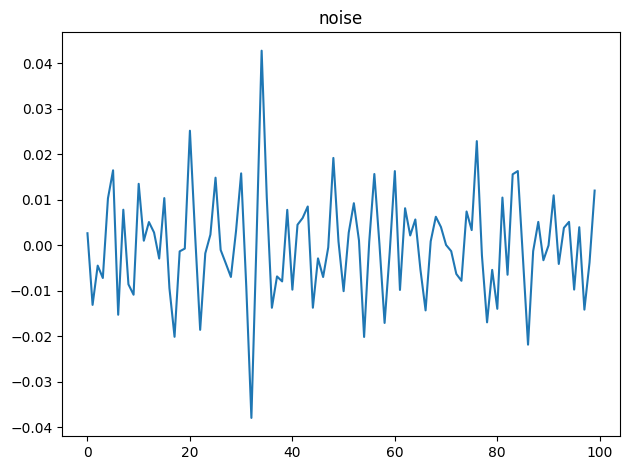

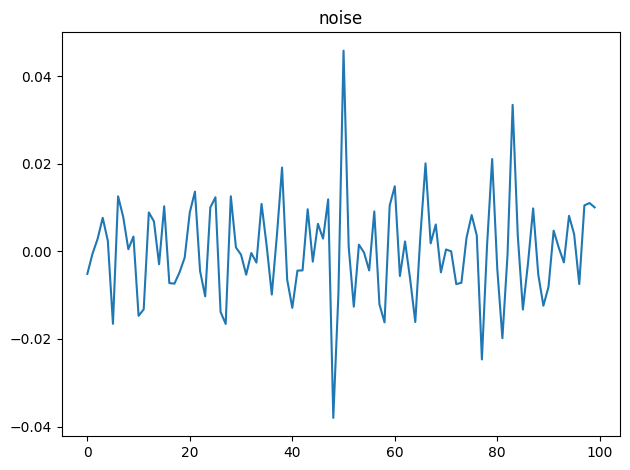

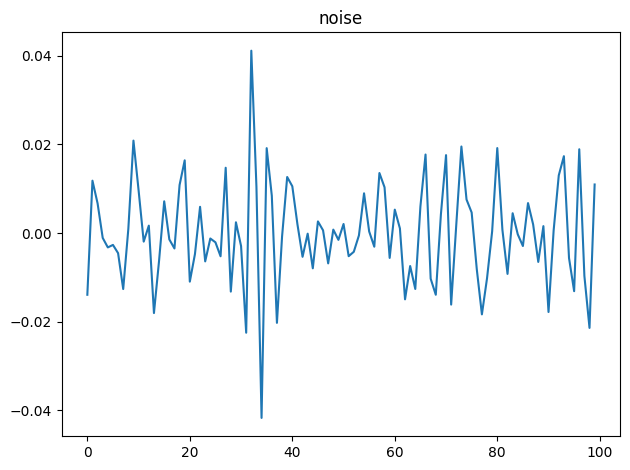

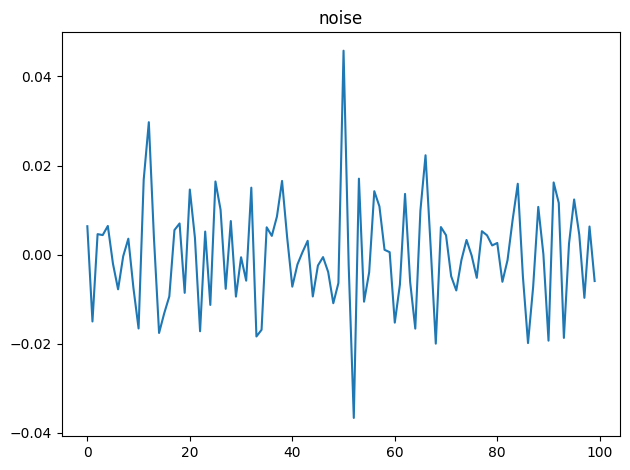

In [ ]:
# plot a few signal events
for trace in x[smask][:5]:
  fig, ax = plt.subplots(1, 1)
  ax.plot(trace)
  ax.set_title("signal")
  fig.tight_layout()
  plt.show()

# plot a few noise events
for trace in x[~smask][:5]:
  fig, ax = plt.subplots(1, 1)
  ax.plot(trace)
  ax.set_title("noise")
  fig.tight_layout()
  plt.show()

We do see a difference between the signal and the noise plots. Signals appear to have some sort of waveform or pattern, while noise events appear more random.

**Network architecture**

Model architecture is similar to the one from section 3.2 in https://arxiv.org/pdf/2112.01031. It uses 2D convolution whereas I use 1D convolution. This is because I only added 1 extra dimension when I loaded the data.

I tried to add an extra dimension as well and used 2D convolutional layers. However, I got no improved results so I chose to stick with 1D Convolutional.

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20
callback_list = [keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss'),
                 keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
                 ]

In [ ]:
model = Sequential()
model.add(Conv1D(5, kernel_size=10, activation='relu', input_shape=(n_samples, 1)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=10))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 91, 5)               │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 91, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 5)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 45)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              46 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

None


Estimate execution time can be obtained by the following formula:


\begin{equation}
  \textrm{Execution time} = \frac{\textrm{FLOPS} \cdot \textrm{Iterations per epoch} \cdot \textrm{Number of epochs}}{\textrm{Hardware FLOPS} \cdot \textrm{Batch size}}
\end{equation}


I don't know the exact specifications for the Google Colab server. However, if it is 160 kFLOPS the execution time will be $\approx 10$ minutes.


In [ ]:
flops = get_flops(model)
print(f"Number of FLOPs: {flops}")
iterations_per_epoch = len(x) // BATCH_SIZE  # Calculate iterations dynamically
exec_time = (flops / 160e3) / BATCH_SIZE * iterations_per_epoch * EPOCHS
print(f"Execution time: {exec_time/60:.3} minutes")

Number of FLOPs: 10096
Execution time: 12.3 minutes


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=callback_list)

Epoch 1/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9780 - loss: 0.0732 - val_accuracy: 0.9788 - val_loss: 0.1637
Epoch 2/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - accuracy: 0.9828 - loss: 0.0570 - val_accuracy: 0.9797 - val_loss: 0.1451
Epoch 3/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.9843 - loss: 0.0520 - val_accuracy: 0.9649 - val_loss: 0.1731
Epoch 4/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9852 - loss: 0.0491 - val_accuracy: 0.9788 - val_loss: 0.1350
Epoch 5/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - accuracy: 0.9866 - loss: 0.0453 - val_accuracy: 0.9704 - val_loss: 0.1551
Epoch 6/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - accuracy: 0.9873 - loss: 0.0438 - val_accuracy: 0.9774 - val_loss: 0.1384
Epoch 7/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.9880 - loss: 0.0414 - val_accuracy: 0.9819 - val_loss: 0.1195
Epoch 8/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 

In [ ]:
model = keras.models.load_model('best_model.keras')
y_predicted = model.predict(x)

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step


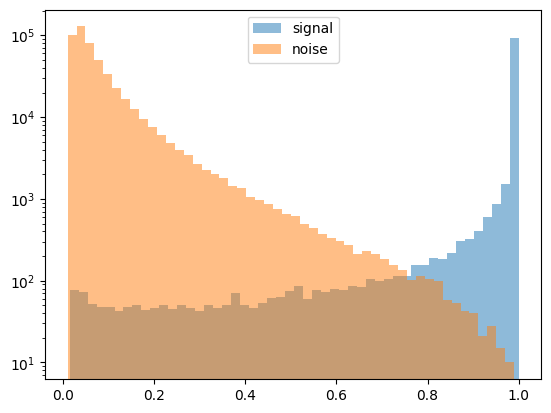

In [ ]:
plt.hist(y_predicted[smask], log=True, alpha=0.5, bins=50, label='signal')
plt.hist(y_predicted[~smask], log=True, alpha=0.5, bins=50, label='noise')
plt.legend()
plt.show()

In [ ]:
def calculate_efficiency_rejection(y, y_predicted, thresholds):
    """
    Calculates signal efficiency and noise reduction factor for given thresholds.
    """

    signal = np.sum(smask)  # Number of signal events
    noise = np.sum(~smask)  # Number of noise events


    signal_efficiency  = np.zeros_like(thresholds)
    noise_reduction_factor  = np.zeros_like(thresholds)

    # Loop through thresholds
    for idx, threshold in enumerate(thresholds):
        # Signal efficiency
        correct_signal = np.sum(y_predicted[smask] > threshold)
        signal_efficiency[idx] = correct_signal / signal

        # Noise rejection (reduction factor)
        correct_noise = np.sum(y_predicted[~smask] <= threshold)
        noise_efficiency = correct_noise / noise
        if noise_efficiency < 1:
            noise_reduction_factor[idx] = 1 / (1 - noise_efficiency)
        else:
            noise_reduction_factor[idx] = noise

    return signal_efficiency, noise_reduction_factor

thresholds = np.linspace(0, 1, 1000)
signal_eff, noise_reject = calculate_efficiency_rejection(y, y_predicted, thresholds)

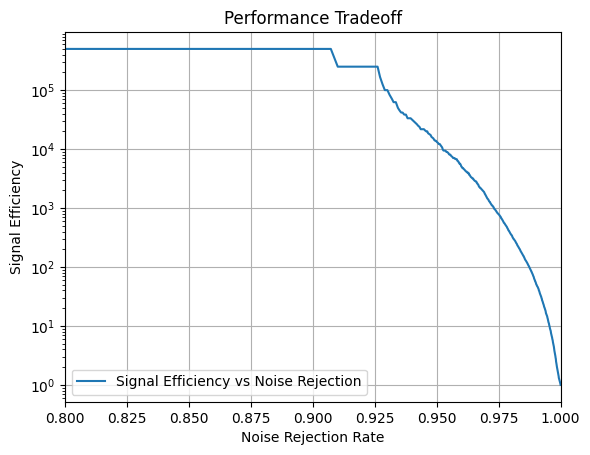

In [ ]:
# Plot efficiency vs rejection
plt.plot(signal_eff, noise_reject, label='Signal Efficiency vs Noise Rejection')
plt.xlabel('Noise Rejection Rate')
plt.ylabel('Signal Efficiency')
plt.title("Performance Tradeoff")
plt.yscale('log')
plt.xlim(0.8, 1)
plt.legend()
plt.grid()
plt.show()


**Different network:**


1.   **Reduced the number of filters**
2.   **Used smaller kernel sizes:** Require fewer computations.
3.   **Replaced dense layers with global pooling:** Dense layers tend to be computationally expensive. I used GlobalMaxPooling1D instead of Flatten + Dense
4.   **Quantized the model:** Convert the network to lower precision



In [ ]:
BATCH_SIZE = 32
EPOCHS = 20
callback_list = [keras.callbacks.ModelCheckpoint(
    filepath='best_model_opt.keras',
    save_best_only=True,
    monitor='val_loss'),
                 keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
                 ]

In [ ]:
# Optimized Network
optimized_model = Sequential()
optimized_model.add(Conv1D(4, kernel_size=5, activation='relu', input_shape=(n_samples, 1)))
optimized_model.add(MaxPooling1D(pool_size=5))
optimized_model.add(Dropout(0.3))
optimized_model.add(GlobalAveragePooling1D())  # Replace Flatten with GlobalAveragePooling
optimized_model.add(Dense(1, activation='sigmoid'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the optimized model
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
optimized_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Check FLOPs for optimized model
optimized_flops = get_flops(optimized_model)
print(f"Optimized FLOPs: {optimized_flops}")
iterations_per_epoch = len(x) // BATCH_SIZE  # Calculate iterations dynamically
exec_time = (optimized_flops / 160e3) / BATCH_SIZE * iterations_per_epoch * EPOCHS
print(f"Execution time: {exec_time/60:.3} minutes")

Optimized FLOPs: 4689
Execution time: 5.72 minutes


In [ ]:
optimized_model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=callback_list)

Epoch 1/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.8430 - loss: 0.4299 - val_accuracy: 0.9024 - val_loss: 0.2403
Epoch 2/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - accuracy: 0.9179 - loss: 0.2167 - val_accuracy: 0.9507 - val_loss: 0.1363
Epoch 3/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.9537 - loss: 0.1392 - val_accuracy: 0.9689 - val_loss: 0.0970
Epoch 4/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.9658 - loss: 0.1095 - val_accuracy: 0.9743 - val_loss: 0.0800
Epoch 5/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.9710 - loss: 0.0944 - val_accuracy: 0.9777 - val_loss: 0.0704
Epoch 6/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9738 - loss: 0.0863 - val_accuracy: 0.9796 - val_loss: 0.0653
Epoch 7/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9755 - loss: 0.0818 - val_accuracy: 0.9818 - val_loss: 0.0608
Epoch 8/20
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 

Despite less FLOPS it takes longer time to train the network?


In [ ]:
optimized_model = keras.models.load_model('best_model_opt.keras')
y_optimized_predicted = optimized_model.predict(x)

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step


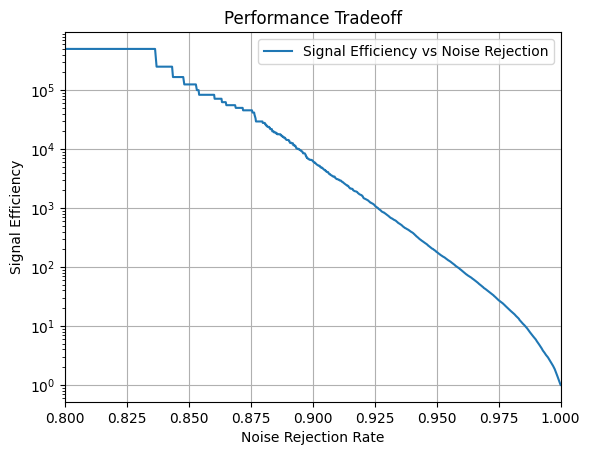

In [ ]:
thresholds = np.linspace(0, 1, 1000)
signal_eff_opt, noise_reject_opt = calculate_efficiency_rejection(y, y_optimized_predicted, thresholds)

# Plot efficiency vs rejection
plt.plot(signal_eff_opt, noise_reject_opt, label='Signal Efficiency vs Noise Rejection')
plt.xlabel('Noise Rejection Rate')
plt.ylabel('Signal Efficiency')
plt.title("Performance Tradeoff")
plt.yscale('log')
plt.xlim(0.8, 1)
plt.legend()
plt.grid()
plt.show()

The results are much worse with this variation of the network.